In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Input,Flatten,Reshape,AveragePooling2D,Dropout,LayerNormalization, ReLU,concatenate,Cropping2D, BatchNormalization
from keras.datasets import mnist
import tensorflow as tf

import keras
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


2024-07-20 19:35:43.744786: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
!wget  -nc https://www.dropbox.com/scl/fi/uaiyxp0t2l8hfcszfadtj/dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius&dl=1
!unzip -n -q dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius

/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
unzip:  cannot find or open dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius, dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.zip or dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.ZIP.

No zipfiles found.


In [4]:
image_path = '../dados/CAPTCHA-10k/treinamento'
def generate_df(image_path):
  label_path = '../dados/CAPTCHA-10k/labels10k'

  jpg_files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]
  jpg_files.sort()
  data = []

  for jpg_file in jpg_files:
      txt_file = os.path.splitext(jpg_file)[0] + '.txt'
      txt_file_path = os.path.join(label_path, txt_file)

      if os.path.exists(txt_file_path):
          with open(txt_file_path, 'r') as file:
              txt_content = file.read().strip()

          data.append({'jpg_file': jpg_file, 'txt_content': txt_content})
  return pd.DataFrame(data)

df = generate_df(image_path)
df.head()

,jpg_file,txt_content
0,000001.jpg,RNINIC
1,000002.jpg,TVCFS8
2,000003.jpg,N1O1EH
3,000004.jpg,OQZSL4
4,000005.jpg,GST2YA


In [5]:
vocab = np.unique(list(df['txt_content'].sum()))
vocab = list(vocab)
vocab.append("*")
np.array(vocab)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', 'A', 'B',
       'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O',
       'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '*'],
      dtype='<U1')

In [6]:
def generate_clean_captcha(char):
    # Fixed parameters
    size = (50, 50)
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2

    # Create a blank white image
    image = np.ones((*size, 1), dtype=np.uint8) * 255  # White background

    # Calculate the position to center the character in the image
    text_size = cv2.getTextSize(char, font, font_scale, font_thickness)[0]
    text_x = (size[1] - text_size[0]) // 2  # Center horizontally
    text_y = (size[0] + text_size[1]) // 2  # Center vertically

    # Draw the character at the calculated position
    cv2.putText(image, char, (text_x, text_y), font, font_scale, (0,), font_thickness, lineType=cv2.LINE_AA)
    
    return image

In [7]:
def preprocess(img):
  kernel  = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
  img     = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  _, img  = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
  return img

In [60]:
def generate_X_Y(image_path):
  df = generate_df(image_path)

  df["index"] = [f"{i}" for i in range(len(df))]
  file_index = (df["index"] + " ") * df['txt_content'].str.len()
  file_index = file_index.sum().split(" ")
  file_index = [int(x) for x in file_index if x] 

  X = [preprocess(cv2.imread(os.path.join(image_path, x),cv2.IMREAD_GRAYSCALE)) for x in df["jpg_file"]]
  X = np.array(X)
  X = np.expand_dims(X, axis=-1)


  X   = X[file_index]
  Y   = np.array([generate_clean_captcha(char) for char in df["txt_content"].sum()])
  pos = np.array([i for text in df["txt_content"] for i,char in enumerate(text)]).reshape(-1,1)
  X = X.astype('float32') / 255.
  Y = Y.astype('float32') / 255.

  labels = np.array([char for char in df["txt_content"].sum()])
  char_to_index = {char: idx for idx, char in enumerate(vocab)}
  num_classes = len(vocab)  # Number of unique characters

  # Step 2: Convert characters to indices
  indices = np.array([char_to_index[char] for char in labels])

  # Step 3: Create one-hot encoded vectors
  one_hot_encoded = np.eye(num_classes)[indices]

  # Create a mapping from index to DataFrame row index


  rows = []
  for row_index, text in enumerate(df["txt_content"]):
      for char_index, char in enumerate(text):
         rows.append(row_index)

  return X,Y,pos,one_hot_encoded,np.array(rows)

X_train,Y_train,pos_train,labels_train,_ = generate_X_Y('../dados/CAPTCHA-10k/treinamento')
X_val,Y_val,pos_val,labels_val,rows_val = generate_X_Y('../dados/CAPTCHA-10k/validacao')

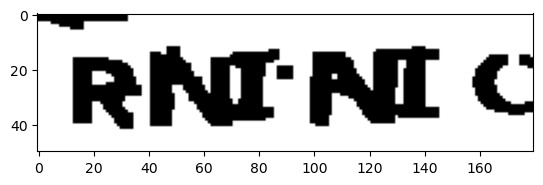

In [9]:
plt.imshow(X_train[0], cmap='gray')

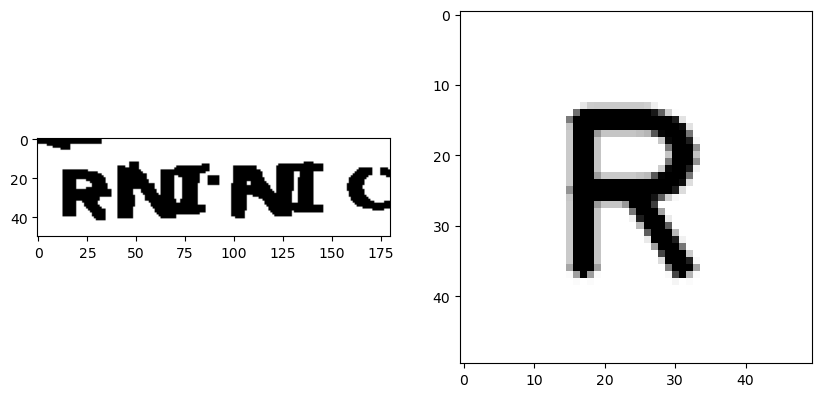

In [10]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(X_train[0], cmap='gray')

# Display the corresponding Y_train[0]
plt.subplot(1, 2, 2)
plt.imshow(Y_train[0], cmap='gray')
plt.show()

In [21]:
def create_tf_dataset(X, Y, pos):
    X_ds = tf.data.Dataset.from_tensor_slices(X)
    Y_ds = tf.data.Dataset.from_tensor_slices(Y)
    POS_ds = tf.data.Dataset.from_tensor_slices(pos)

    dataset = tf.data.Dataset.zip(((X_ds, POS_ds), Y_ds))
    
    def preprocess_data(inputs, Y):
        X, POS = inputs
        return (X, POS), Y

    dataset = dataset.map(preprocess_data)
    return dataset

# Create the dataset
train_set   = create_tf_dataset(X_train, Y_train, pos_train)
val_set     = create_tf_dataset(X_val, Y_val, pos_val)


# Shuffle and batch the dataset
batch_size  = 64
train_set   = train_set.batch(batch_size)
val_set     = val_set.batch(batch_size)

In [18]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

In [19]:
autoencoder = tf.keras.models.load_model('model_BCE_aug_best_unet.tf',custom_objects={"rmse": rmse,"psnr":psnr})

2024-07-20 19:38:21.529425: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13773 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


In [22]:
Y_train_pred_ae = autoencoder.predict(train_set)
Y_val_pred_ae = autoencoder.predict(val_set)

2024-07-20 19:38:55.235405: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-07-20 19:38:56.828828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


94/94 [==============================] - 5s 51ms/step


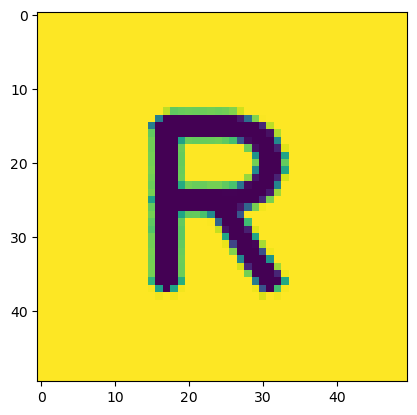

In [25]:
plt.imshow(Y_train_pred_ae[0])

In [26]:
bins = np.arange(0,180,180//7)

In [27]:
X_train_class,Y_train_class = Y_train_pred_ae,labels_train
X_val_class,Y_val_class = Y_val_pred_ae,labels_val

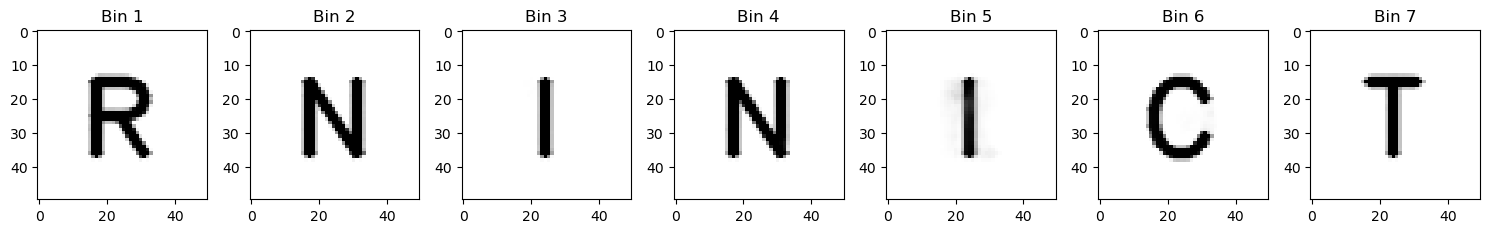

In [28]:
# Create subplots
num_bins = 7
fig, axes = plt.subplots(1, num_bins, figsize=(15, 5))

# Plot each bin separately
for i in range(num_bins):
    bin_slice = X_train_class[i]
    axes[i].imshow(bin_slice, cmap='gray')
    axes[i].set_title(f'Bin {i+1}')
plt.tight_layout()
plt.show()

In [29]:
def conv_bn_relu(filters, kernel_size, strides=(1, 1), padding='same'):
    def layer(x):
        x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        return x
    return layer

def crop(x1, x2):
    # Crop x2 to the shape of x1
    x1_shape = x1.shape
    x2_shape = x2.shape
    height_diff = x2_shape[1] - x1_shape[1]
    width_diff = x2_shape[2] - x1_shape[2]

    cropping = ((height_diff // 2, height_diff - height_diff // 2),
                (width_diff // 2, width_diff - width_diff // 2))
    x2_cropped = Cropping2D(cropping)(x2)
    return x2_cropped

In [30]:
def classifier(input_img, num_blocks=1, num_downsample=3,n_out = 38):
    x = input_img

    for _ in range(2):
        x = conv_bn_relu(32, (3, 3))(x)

    # Contracting path
    for _ in range(num_downsample):
        for _ in range(num_blocks):
            x = conv_bn_relu(32, (3, 3))(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Bottleneck
    for _ in range(num_blocks):
        x = conv_bn_relu(32, (3, 3))(x)
    x = Conv2D(16, (1, 1), activation='relu')(x)

    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(n_out, activation='softmax')(x)

    return tf.keras.Model(inputs=input_img, outputs=output)


input_shape = X_train_class.shape[1:]  # Example input shape
input_img = Input(shape=input_shape)
model = classifier(input_img, num_blocks=1, num_downsample=5)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 50, 50, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 50, 50, 32)        128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 50, 50, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 50, 50, 32)        128       
 chNormalization)                                            

In [31]:
checkpoint = ModelCheckpoint(
    'classifier_aug_best.tf',
    monitor='val_accuracy',  # Use 'val_loss' as an approximation of RMSE if the metric isn't directly available
    save_best_only=True,
    mode='max',
    verbose=1
)

In [32]:
datagen = ImageDataGenerator(
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

datagen.fit(X_train_class)
batch_size = 64
augmented_data_generator = datagen.flow(X_train_class, Y_train_class, batch_size=batch_size)

In [74]:
pos_train[0]

array([0])

In [33]:
history = model.fit(augmented_data_generator,
                steps_per_epoch=len(X_train_class) // batch_size,
                epochs=50,
                batch_size=batch_size,
                shuffle=True,
                callbacks=[checkpoint],
                validation_data=(X_val_class, Y_val_class))

Epoch 1/50


2024-07-20 19:40:24.526933: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7172d890c7d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-20 19:40:24.526971: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-07-20 19:40:24.531250: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-20 19:40:24.645946: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


748/750 [============================>.] - ETA: 0s - loss: 0.4373 - accuracy: 0.9025
Epoch 1: val_accuracy improved from -inf to 0.89968, saving model to classifier_aug_best.tf
INFO:tensorflow:Assets written to: classifier_aug_best.tf/assets


INFO:tensorflow:Assets written to: classifier_aug_best.tf/assets


750/750 [==============================] - 23s 23ms/step - loss: 0.4363 - accuracy: 0.9028 - val_loss: 0.4923 - val_accuracy: 0.8997
Epoch 2/50
750/750 [==============================] - ETA: 0s - loss: 0.0933 - accuracy: 0.9794
Epoch 2: val_accuracy did not improve from 0.89968
750/750 [==============================] - 14s 19ms/step - loss: 0.0933 - accuracy: 0.9794 - val_loss: 1.3459 - val_accuracy: 0.6732
Epoch 3/50
750/750 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.9791
Epoch 3: val_accuracy did not improve from 0.89968
750/750 [==============================] - 14s 19ms/step - loss: 0.0859 - accuracy: 0.9791 - val_loss: 2.9574 - val_accuracy: 0.5629
Epoch 4/50
748/750 [============================>.] - ETA: 0s - loss: 0.0822 - accuracy: 0.9804
Epoch 4: val_accuracy improved from 0.89968 to 0.92285, saving model to classifier_aug_best.tf
INFO:tensorflow:Assets written to: classifier_aug_best.tf/assets


INFO:tensorflow:Assets written to: classifier_aug_best.tf/assets


750/750 [==============================] - 17s 23ms/step - loss: 0.0823 - accuracy: 0.9804 - val_loss: 0.5096 - val_accuracy: 0.9228
Epoch 5/50
749/750 [============================>.] - ETA: 0s - loss: 0.0831 - accuracy: 0.9793
Epoch 5: val_accuracy did not improve from 0.92285
750/750 [==============================] - 16s 22ms/step - loss: 0.0831 - accuracy: 0.9793 - val_loss: 1.3229 - val_accuracy: 0.6679
Epoch 6/50
749/750 [============================>.] - ETA: 0s - loss: 0.0792 - accuracy: 0.9807
Epoch 6: val_accuracy did not improve from 0.92285
750/750 [==============================] - 15s 20ms/step - loss: 0.0791 - accuracy: 0.9808 - val_loss: 4.6423 - val_accuracy: 0.3991
Epoch 7/50
748/750 [============================>.] - ETA: 0s - loss: 0.0756 - accuracy: 0.9812
Epoch 7: val_accuracy did not improve from 0.92285
750/750 [==============================] - 15s 20ms/step - loss: 0.0754 - accuracy: 0.9813 - val_loss: 0.4273 - val_accuracy: 0.8664
Epoch 8/50
750/750 [=======

INFO:tensorflow:Assets written to: classifier_aug_best.tf/assets


750/750 [==============================] - 18s 23ms/step - loss: 0.0757 - accuracy: 0.9808 - val_loss: 0.3540 - val_accuracy: 0.9468
Epoch 11/50
748/750 [============================>.] - ETA: 0s - loss: 0.0707 - accuracy: 0.9814
Epoch 11: val_accuracy did not improve from 0.94684
750/750 [==============================] - 15s 20ms/step - loss: 0.0708 - accuracy: 0.9814 - val_loss: 0.6866 - val_accuracy: 0.8674
Epoch 12/50
750/750 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9809
Epoch 12: val_accuracy did not improve from 0.94684
750/750 [==============================] - 15s 19ms/step - loss: 0.0717 - accuracy: 0.9809 - val_loss: 0.4231 - val_accuracy: 0.8997
Epoch 13/50
748/750 [============================>.] - ETA: 0s - loss: 0.0695 - accuracy: 0.9824
Epoch 13: val_accuracy did not improve from 0.94684
750/750 [==============================] - 15s 20ms/step - loss: 0.0695 - accuracy: 0.9824 - val_loss: 2.1974 - val_accuracy: 0.3751
Epoch 14/50
750/750 [

INFO:tensorflow:Assets written to: classifier_aug_best.tf/assets


750/750 [==============================] - 17s 22ms/step - loss: 0.0626 - accuracy: 0.9828 - val_loss: 0.3377 - val_accuracy: 0.9488
Epoch 26/50
748/750 [============================>.] - ETA: 0s - loss: 0.0621 - accuracy: 0.9830
Epoch 26: val_accuracy did not improve from 0.94884
750/750 [==============================] - 14s 19ms/step - loss: 0.0621 - accuracy: 0.9830 - val_loss: 0.8075 - val_accuracy: 0.7902
Epoch 27/50
750/750 [==============================] - ETA: 0s - loss: 0.0620 - accuracy: 0.9828
Epoch 27: val_accuracy did not improve from 0.94884
750/750 [==============================] - 14s 19ms/step - loss: 0.0620 - accuracy: 0.9828 - val_loss: 10.5232 - val_accuracy: 0.1788
Epoch 28/50
750/750 [==============================] - ETA: 0s - loss: 0.0620 - accuracy: 0.9831
Epoch 28: val_accuracy did not improve from 0.94884
750/750 [==============================] - 14s 19ms/step - loss: 0.0620 - accuracy: 0.9831 - val_loss: 1.9758 - val_accuracy: 0.7542
Epoch 29/50
749/750 

INFO:tensorflow:Assets written to: classifier_aug_best.tf/assets


750/750 [==============================] - 16s 21ms/step - loss: 0.0622 - accuracy: 0.9826 - val_loss: 0.2626 - val_accuracy: 0.9495
Epoch 30/50
748/750 [============================>.] - ETA: 0s - loss: 0.0616 - accuracy: 0.9830
Epoch 30: val_accuracy did not improve from 0.94951
750/750 [==============================] - 14s 19ms/step - loss: 0.0616 - accuracy: 0.9830 - val_loss: 0.2872 - val_accuracy: 0.9463
Epoch 31/50
749/750 [============================>.] - ETA: 0s - loss: 0.0605 - accuracy: 0.9829
Epoch 31: val_accuracy did not improve from 0.94951
750/750 [==============================] - 14s 19ms/step - loss: 0.0605 - accuracy: 0.9829 - val_loss: 2.6433 - val_accuracy: 0.6047
Epoch 32/50
748/750 [============================>.] - ETA: 0s - loss: 0.0610 - accuracy: 0.9830
Epoch 32: val_accuracy did not improve from 0.94951
750/750 [==============================] - 14s 19ms/step - loss: 0.0609 - accuracy: 0.9831 - val_loss: 0.9149 - val_accuracy: 0.7490
Epoch 33/50
748/750 [

INFO:tensorflow:Assets written to: classifier_aug_best.tf/assets


750/750 [==============================] - 16s 22ms/step - loss: 0.0599 - accuracy: 0.9830 - val_loss: 0.3186 - val_accuracy: 0.9502
Epoch 39/50
750/750 [==============================] - ETA: 0s - loss: 0.0582 - accuracy: 0.9833
Epoch 39: val_accuracy did not improve from 0.95017
750/750 [==============================] - 14s 19ms/step - loss: 0.0582 - accuracy: 0.9833 - val_loss: 0.4689 - val_accuracy: 0.9378
Epoch 40/50
750/750 [==============================] - ETA: 0s - loss: 0.0582 - accuracy: 0.9833
Epoch 40: val_accuracy did not improve from 0.95017
750/750 [==============================] - 14s 19ms/step - loss: 0.0582 - accuracy: 0.9833 - val_loss: 0.3200 - val_accuracy: 0.9323
Epoch 41/50
748/750 [============================>.] - ETA: 0s - loss: 0.0574 - accuracy: 0.9835
Epoch 41: val_accuracy did not improve from 0.95017
750/750 [==============================] - 15s 20ms/step - loss: 0.0573 - accuracy: 0.9835 - val_loss: 1.5849 - val_accuracy: 0.6341
Epoch 42/50
749/750 [

In [34]:
model = tf.keras.models.load_model('classifier_aug_best.tf')

In [35]:
Y_train_pred = model.predict(X_train_class)
Y_val_pred = model.predict(X_val_class)

188/188 [==============================] - 1s 4ms/step


In [36]:
from sklearn.metrics import accuracy_score,classification_report

# Convert one-hot encoded labels to class indices for true labels
Y_val_class_indices = np.argmax(Y_val_class, axis=-1)

# Convert predictions to class indices
Y_val_pred_class_indices = np.argmax(Y_val_pred, axis=-1)

# Compute accuracy
accuracy = accuracy_score(Y_val_class_indices, Y_val_pred_class_indices)
print(f'Classification Accuracy: {accuracy}')

Classification Accuracy: 0.9501749708381937


In [37]:
report = classification_report(Y_val_class_indices, Y_val_pred_class_indices, output_dict=True, zero_division=0)
for label, metrics in report.items():
    if label.isdecimal():
        print(f'Class {vocab[int(label)]}:')
        print(f"  Precision: {metrics['precision']:.2f}")
        print(f"  Recall: {metrics['recall']:.2f}")
        print(f"  F1-score: {metrics['f1-score']:.2f}")
        print(f"  Support: {metrics['support']:.2f}\n")
    else:
        print(label,metrics)


Class 0:
  Precision: 0.90
  Recall: 0.86
  F1-score: 0.88
  Support: 184.00

Class 1:
  Precision: 0.95
  Recall: 0.92
  F1-score: 0.94
  Support: 198.00

Class 2:
  Precision: 0.98
  Recall: 0.99
  F1-score: 0.98
  Support: 162.00

Class 3:
  Precision: 0.98
  Recall: 0.91
  F1-score: 0.94
  Support: 138.00

Class 4:
  Precision: 0.96
  Recall: 0.98
  F1-score: 0.97
  Support: 153.00

Class 5:
  Precision: 0.95
  Recall: 0.98
  F1-score: 0.96
  Support: 161.00

Class 6:
  Precision: 0.96
  Recall: 0.97
  F1-score: 0.96
  Support: 175.00

Class 7:
  Precision: 0.99
  Recall: 0.97
  F1-score: 0.98
  Support: 189.00

Class 8:
  Precision: 0.90
  Recall: 0.94
  F1-score: 0.92
  Support: 147.00

Class 9:
  Precision: 0.92
  Recall: 0.96
  F1-score: 0.94
  Support: 150.00

Class ?:
  Precision: 0.00
  Recall: 0.00
  F1-score: 0.00
  Support: 0.00

Class A:
  Precision: 0.98
  Recall: 0.97
  F1-score: 0.98
  Support: 150.00

Class B:
  Precision: 0.94
  Recall: 0.96
  F1-score: 0.95
  Suppo

In [38]:
import cv2
def draw_red_box_cv2(image, start_x, end_x, height=50):
    # Create a copy of the Simage
    image_copy = image.copy()
    
    # Define the rectangle color (BGR format for OpenCV)
    color = (0, 0, 255)  # Red color in BGR
    thickness = 2  # Thickness of the rectangle
    
    # Draw the rectangle
    top_left = (start_x, 0)
    bottom_right = (end_x, height)
    cv2.rectangle(image_copy, top_left, bottom_right, color, thickness)
    
    return image_copy

Number of misclassified instances: 299
Number of misclassified images: 260


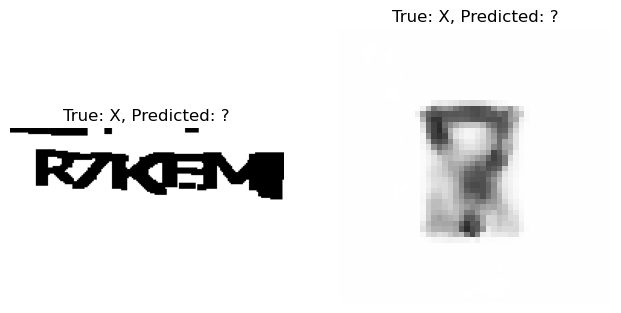

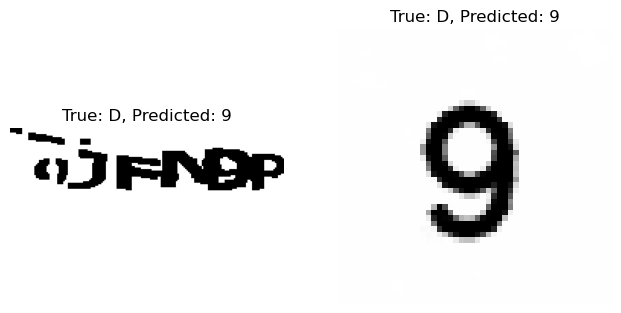

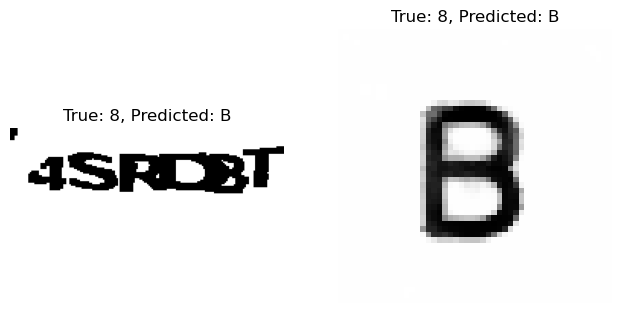

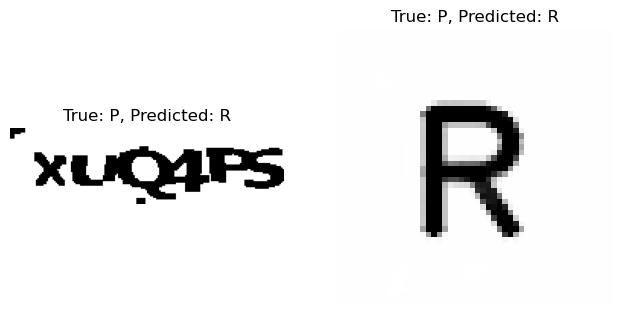

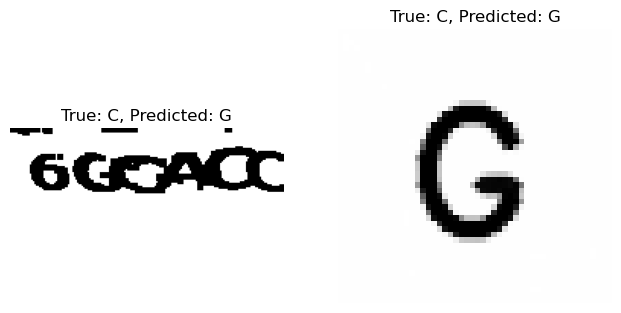

In [46]:
misclassified_indices = np.where(Y_val_class_indices != Y_val_pred_class_indices)[0]
print(f"Number of misclassified instances: {len(misclassified_indices)}")
print(f"Number of misclassified images: {len(np.unique(misclassified_indices//7))}")

# Print the first few misclassified instances
for i in misclassified_indices[:5]:  # Adjust the number as needed

    original_image  = X_val[i]  # Original image
    predicted_image = Y_val_pred_ae[i]# Remove the single channel dimension if it exists

    plt.figure(figsize=(12, 6))  # Adjust the size as needed
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    plt.title(f"True: {vocab[Y_val_class_indices[i]]}, Predicted: {vocab[Y_val_pred_class_indices[i]]}")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB))
    plt.title(f"True: {vocab[Y_val_class_indices[i]]}, Predicted: {vocab[Y_val_pred_class_indices[i]]}")
    plt.axis('off')
    plt.show()

In [70]:
images_that_has_some_error = rows_val[misclassified_indices]
unique_miss = len(np.unique(images_that_has_some_error))
unique_miss /=X_val.shape[0]
1 - unique_miss

0.956507248791868

In [41]:
model.save('classifier_aug_20.keras')